# Sentiments Analysis with BERT

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
data = pd.read_csv("C:/Users/ikry/OneDrive/Desktop/MSc DS/PROJECTS/sentimentdataset.csv")
data.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [5]:
# Data cleaning
# drop column Unnamed: 0.1
data.drop(columns='Unnamed: 0.1',inplace=True)
# Rename column Unnamed: 0 to id
data.rename(columns={'Unnamed: 0':'Id'},inplace=True)

#converting Timestamp column in three new columns ('Day', 'Month', and 'Year')
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Day'] = data['Timestamp'].dt.day
data['Month'] = data['Timestamp'].dt.month
data['Year'] = data['Timestamp'].dt.year

# removes leading and trailing whitespaces from each string in the column
data['Text']= data['Text'].str.strip()
data['Sentiment']= data['Sentiment'].str.strip()
data['User']= data['User'].str.strip()
data['Platform']= data['Platform'].str.strip()
data['Hashtags']= data['Hashtags'].str.strip()
data['Country']= data['Country'].str.strip()

In [6]:
data.head()

,Id,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,Enjoying a beautiful day at the park!,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,Traffic was terrible this morning.,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,Just finished an amazing workout! 💪,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,Excited about the upcoming weekend getaway!,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,Trying out a new recipe for dinner tonight.,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


## Visualizing data

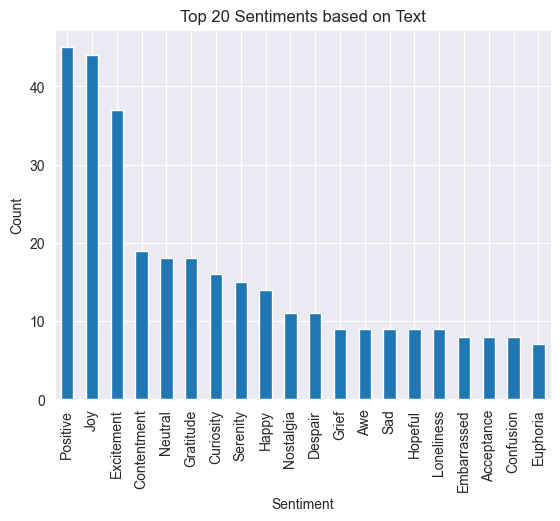

In [7]:

data['Sentiment'].value_counts().nlargest(20).plot(kind='bar')
plt.title('Top 20 Sentiments based on Text')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

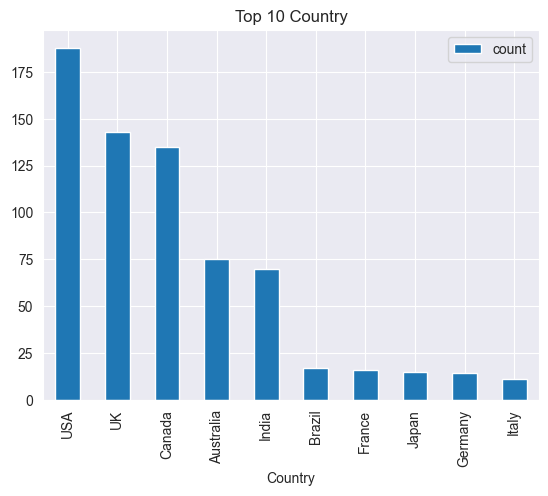

In [8]:
data['Country'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 Country')
plt.legend()
plt.show()

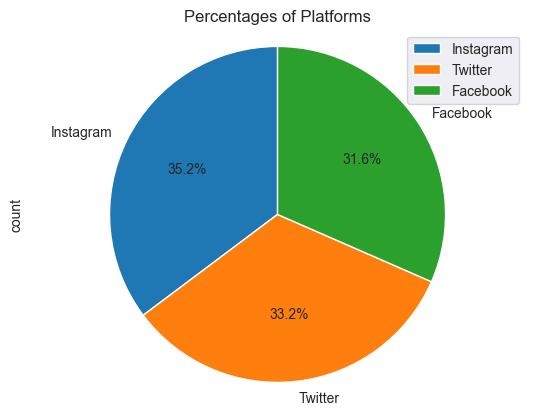

In [9]:
data['Platform'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Percentages of Platforms')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend()
plt.show()

In [10]:
Facebook=data[data['Platform']=='Facebook']
Twitter=data[data['Platform']=='Twitter']
Instagram=data[data['Platform']=='Instagram']

## WordCloud

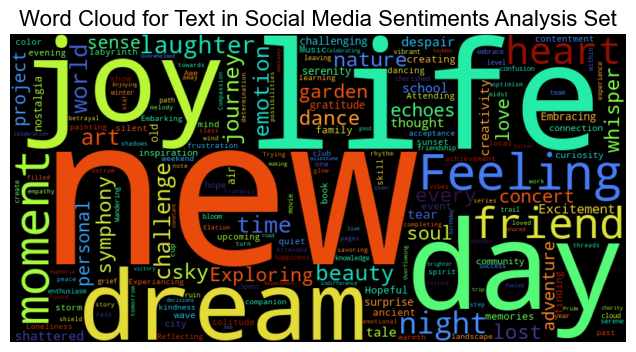

In [11]:
from wordcloud import WordCloud

def create_wordcloud(data, column, title):
    
    #This setting disables the detection of collocations (multi-word phrases) to focus on individual words.
    wordcloud = WordCloud(width=800, height=400, background_color='black',
                          colormap='turbo', collocations=False).generate(' '.join(data[column]))

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {column} in {title}', fontsize=16, color='black')
    plt.axis('off')
    plt.show()
    
create_wordcloud(data, 'Text', 'Social Media Sentiments Analysis Set')

## Bert-large-cased Model

In [12]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' 

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
sample_txt = 'Enjoying a beautiful day at the park!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Enjoying a beautiful day at the park!
   Tokens: ['En', '##joy', '##ing', 'a', 'beautiful', 'day', 'at', 'the', 'park', '!']
Token IDs: [13832, 18734, 1158, 170, 2712, 1285, 1120, 1103, 2493, 106]


In [16]:


encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

C:\Users\ikry\OneDrive\Documents\GitHub\python-exercises\venv\lib\site-packages\transformers\tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\ikry\AppData\Local\Temp\ipykernel_1756\3378048011.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


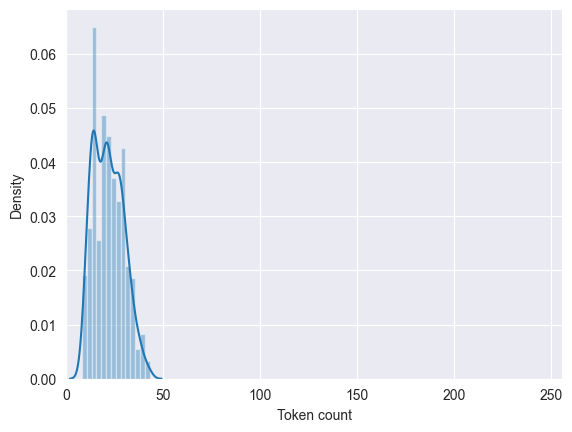

In [17]:
token_lens = []

for txt in data.Text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512)
      token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

## Distilbert Model

In [18]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'

In [19]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [20]:
sample_txt = 'Enjoying a beautiful day at the park!'

In [21]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Enjoying a beautiful day at the park!
   Tokens: ['enjoying', 'a', 'beautiful', 'day', 'at', 'the', 'park', '!']
Token IDs: [9107, 1037, 3376, 2154, 2012, 1996, 2380, 999]


In [22]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

C:\Users\ikry\OneDrive\Documents\GitHub\python-exercises\venv\lib\site-packages\transformers\tokenization_utils_base.py:2211: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [23]:
token_lens = []

for txt in data.Text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512)
      token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


C:\Users\ikry\AppData\Local\Temp\ipykernel_1756\533070193.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


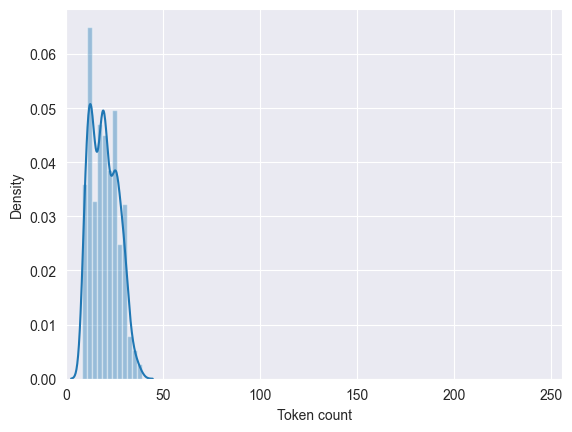

In [24]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');